In [1]:
# 1 Imports & Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
Sequential = tf.keras.models.Sequential
GRU = tf.keras.layers.GRU
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
EarlyStopping = tf.keras.callbacks.EarlyStopping

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GRU, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

In [2]:
# 2 Data Preparation

df = pd.read_csv("bangalore_inflation_dataset.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print("📊 Dataset shape:", df.shape)
print(df.head())

features = df.drop(columns=["Date"])
target = df["CPI"]  

train_size = int(len(features) * 0.8)

X_train = features.iloc[:train_size]
X_test = features.iloc[train_size:]
y_train = target.iloc[:train_size]
y_test = target.iloc[train_size:]

print(f"✅ Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("🔄 Features normalized (0-1 range).")


📊 Dataset shape: (200, 13)
        Date  CPI  GDP_Growth  Unemployment_Rate  Crude_Oil_Prices  \
0 2007-01-31 4.32        2.25               7.22             41.38   
1 2007-02-28 5.55        7.24              10.23             57.09   
2 2007-03-31 4.20        4.73               7.42             63.80   
3 2007-04-30 4.75        3.62               5.80             98.32   
4 2007-05-31 7.76        4.75               6.89             78.35   

   Gold_Prices  Real_Estate_Index  Stock_Index  Money_Supply_M1  \
0      1537.04             135.25     21528.19             5.83   
1      1585.09             136.28     21842.67             5.20   
2      1544.46             123.95     30149.44             6.35   
3      1755.77             126.87     24002.05            10.48   
4      1309.54             140.20     26346.39             7.32   

   Money_Supply_M2  Industrial_Production  Retail_Sales  Exchange_Rate  
0             9.41                   5.49          8.97          73.92  
1  

In [3]:
# 3 Feature Engineering

df_fe = df.copy()

for col in ["CPI", "GDP_Growth", "Unemployment_Rate"]:
    df_fe[f"{col}_lag1"] = df_fe[col].shift(1)
    df_fe[f"{col}_lag3"] = df_fe[col].shift(3)

for col in ["CPI", "Crude_Oil_Prices", "Gold_Prices", "Stock_Index"]:
    df_fe[f"{col}_ma3"] = df_fe[col].rolling(window=3).mean()
    df_fe[f"{col}_ma6"] = df_fe[col].rolling(window=6).mean()

for col in ["Stock_Index", "Crude_Oil_Prices"]:
    df_fe[f"{col}_volatility"] = df_fe[col].rolling(window=3).std()

df_fe["Gold_to_Oil"] = df_fe["Gold_Prices"] / df_fe["Crude_Oil_Prices"]
df_fe["M1_to_M2"] = df_fe["Money_Supply_M1"] / df_fe["Money_Supply_M2"]

df_fe = df_fe.dropna().reset_index(drop=True)

print("📊 Feature engineering completed!")
print("New shape:", df_fe.shape)
print(df_fe.head())

📊 Feature engineering completed!
New shape: (195, 31)
        Date  CPI  GDP_Growth  Unemployment_Rate  Crude_Oil_Prices  \
0 2007-06-30 6.99        5.63               4.87             49.97   
1 2007-07-31 3.20        4.79               6.90             77.29   
2 2007-08-31 6.68        1.59               6.00             46.79   
3 2007-09-30 6.80        7.79               8.10             86.24   
4 2007-10-31 3.49        8.55               6.34             62.93   

   Gold_Prices  Real_Estate_Index  Stock_Index  Money_Supply_M1  \
0      1364.60              85.65     21627.30            11.54   
1      1345.47             145.47     21660.44            10.10   
2      1666.04             134.33     27245.95             4.09   
3      1680.08             122.99     19951.27            11.96   
4      1590.25             160.00     22754.36            12.43   

   Money_Supply_M2  Industrial_Production  Retail_Sales  Exchange_Rate  \
0            13.78                   3.75       

In [4]:
# 4 Sequence Data Preparation

features = df_fe.drop(columns=["Date"])
target = df_fe["CPI"]

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 12 
X_seq, y_seq = create_sequences(features_scaled, target, TIME_STEPS)

print("📊 Sequence data shape:", X_seq.shape, y_seq.shape)

train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"✅ Sequences ready! Train: {X_train.shape}, Test: {X_test.shape}")

📊 Sequence data shape: (183, 12, 30) (183,)
✅ Sequences ready! Train: (146, 12, 30), Test: (37, 12, 30)


In [5]:
# 5 GRU-RNN Model

model = Sequential([
    GRU(64, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  # Regularization
    GRU(32, activation="tanh"),
    Dropout(0.2),
    Dense(1)  # Predict CPI
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

c:\Web development\GRU-RNN_InflationModel\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,873 (108.88 KB)

 Trainable params: 27,873 (108.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - loss: 23.2148 - mae: 4.5105 - val_loss: 9.8728 - val_mae: 2.8222
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 5.2918 - mae: 1.8368 - val_loss: 2.3437 - val_mae: 1.2200
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.4796 - mae: 1.2845 - val_loss: 2.2766 - val_mae: 1.2088
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.9920 - mae: 1.3470 - val_loss: 2.2465 - val_mae: 1.1989
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 2.7554 - mae: 1.3241 - val_loss: 2.1473 - val_mae: 1.1735
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.6918 - mae: 1.3065 - val_loss: 2.1480 - val_mae: 1.1743
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 2.9548 - mae: 1.3829 - val_loss: 2.1569 - val_mae: 1.1753
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.0048 - mae: 1.3654 - val_loss: 2.1346 - val_mae: 1.1711
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step -

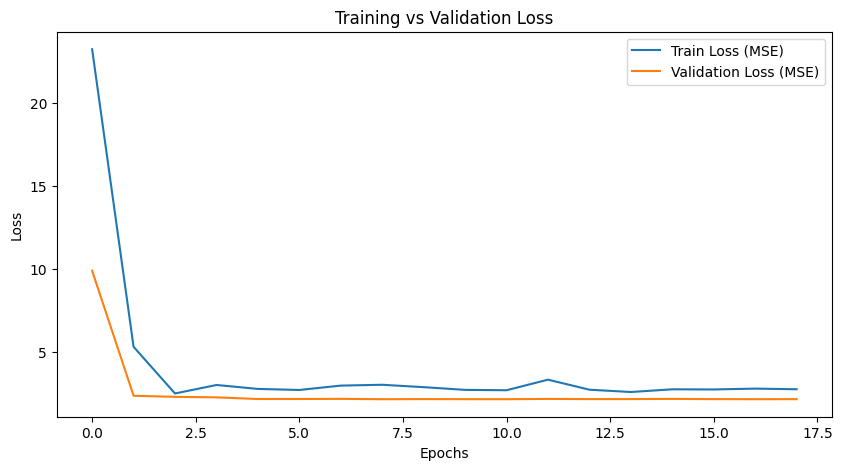

✅ Test MSE: 2.1346, Test MAE: 1.1711
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


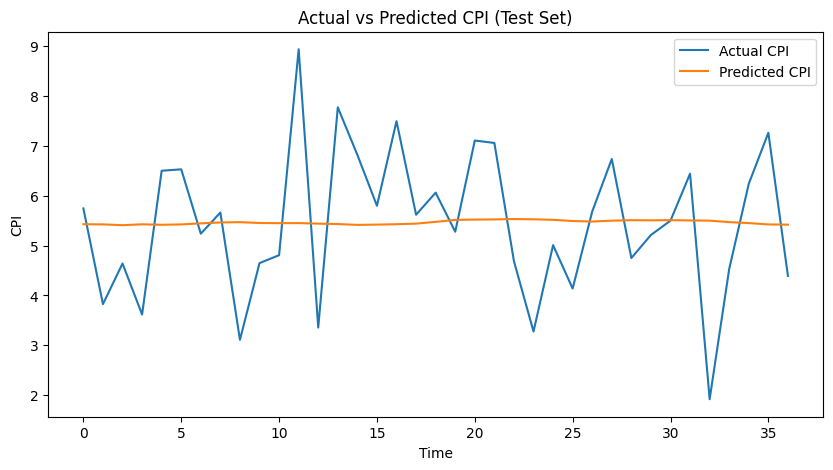

In [6]:
# 6 Training & Evaluation

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Validation Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

y_pred = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual CPI")
plt.plot(y_pred, label="Predicted CPI")
plt.xlabel("Time")
plt.ylabel("CPI")
plt.legend()
plt.title("Actual vs Predicted CPI (Test Set)")
plt.show()

In [7]:
# 7 Fine-tuned GRU Model
# from tensorflow.keras.regularizers import l2
l2 = tf.keras.regularizers.l2

model = Sequential([
    GRU(128, activation="tanh", return_sequences=True,
        kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    GRU(64, activation="tanh", kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 12, 128)        │        61,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,801 (393.75 KB)

 Trainable params: 100,801 (393.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - loss: 23.4538 - mae: 4.5321 - val_loss: 15.5238 - val_mae: 3.6284
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 9.9434 - mae: 2.6596 - val_loss: 3.9107 - val_mae: 1.5756
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3952 - mae: 1.4135 - val_loss: 2.5559 - val_mae: 1.2312
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.3992 - mae: 1.4307 - val_loss: 2.5771 - val_mae: 1.2392
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.1924 - mae: 1.3575 - val_loss: 2.3825 - val_mae: 1.1790
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.1217 - mae: 1.3905 - val_loss: 2.6277 - val_mae: 1.2399
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 3.2516 - mae: 1.4010 - val_loss: 2.3800 - val_mae: 1.1790
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.1459 - mae: 1.3539 - val_loss: 2.3319 - val_mae: 1.1699
Epoch 9/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step 

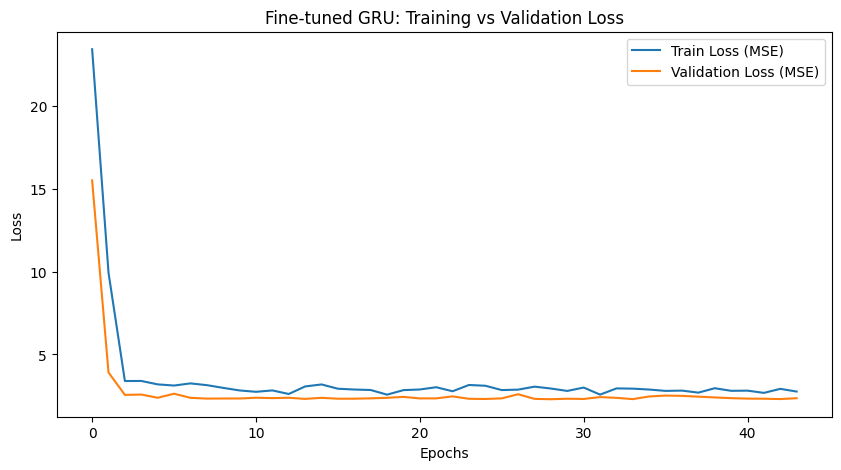

✅ Fine-tuned Test MSE: 2.2948, Test MAE: 1.1690
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  


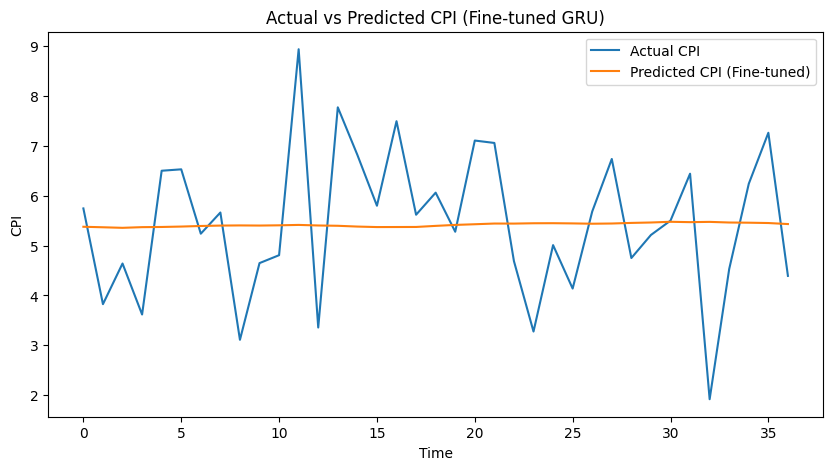

In [8]:
# Retrain Fine-tuned Model

early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

history_ft = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(10, 5))
plt.plot(history_ft.history["loss"], label="Train Loss (MSE)")
plt.plot(history_ft.history["val_loss"], label="Validation Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Fine-tuned GRU: Training vs Validation Loss")
plt.show()

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Fine-tuned Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

y_pred_ft = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual CPI")
plt.plot(y_pred_ft, label="Predicted CPI (Fine-tuned)")
plt.xlabel("Time")
plt.ylabel("CPI")
plt.legend()
plt.title("Actual vs Predicted CPI (Fine-tuned GRU)")
plt.show()

In [9]:
# 7b Add Seasonal Features + Longer Lags

df_seasonal = df_fe.copy()

df_seasonal["month"] = df_seasonal["Date"].dt.month
df_seasonal["month_sin"] = np.sin(2 * np.pi * df_seasonal["month"] / 12)
df_seasonal["month_cos"] = np.cos(2 * np.pi * df_seasonal["month"] / 12)

for col in ["CPI", "GDP_Growth", "Unemployment_Rate"]:
    df_seasonal[f"{col}_lag6"] = df_seasonal[col].shift(6)
    df_seasonal[f"{col}_lag12"] = df_seasonal[col].shift(12)

df_seasonal = df_seasonal.drop(columns=["month"])

df_seasonal = df_seasonal.dropna().reset_index(drop=True)

print("📊 Added seasonality + deeper lags")
print(df_seasonal.head())


📊 Added seasonality + deeper lags
        Date  CPI  GDP_Growth  Unemployment_Rate  Crude_Oil_Prices  \
0 2008-06-30 5.64        6.16               7.44             27.52   
1 2008-07-31 6.01        6.91               7.47             63.23   
2 2008-08-31 3.25        8.91               4.69             78.28   
3 2008-09-30 6.84        7.41               6.67             88.00   
4 2008-10-31 7.02        7.58               8.01             63.05   

   Gold_Prices  Real_Estate_Index  Stock_Index  Money_Supply_M1  \
0      1395.11             143.33     23147.53             9.63   
1      1352.94             111.39     27584.29             8.81   
2      1644.30             124.01     26683.94             6.45   
3      1289.97             120.60     19881.42             8.80   
4      1651.50             125.17     25054.44            10.81   

   Money_Supply_M2  Industrial_Production  Retail_Sales  Exchange_Rate  \
0            14.09                   4.04          4.10          60.

✅ New sequences ready! Train: (136, 12, 38), Test: (35, 12, 38)


c:\Web development\GRU-RNN_InflationModel\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step - loss: 24.4108 - mae: 4.5957 - val_loss: 14.3109 - val_mae: 3.4598
Epoch 2/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 8.6850 - mae: 2.4446 - val_loss: 3.4960 - val_mae: 1.4543
Epoch 3/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.3510 - mae: 1.4244 - val_loss: 2.7937 - val_mae: 1.2966
Epoch 4/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.0476 - mae: 1.5772 - val_loss: 2.6601 - val_mae: 1.2646
Epoch 5/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 3.1786 - mae: 1.3685 - val_loss: 2.4017 - val_mae: 1.1837
Epoch 6/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 3.2398 - mae: 1.3743 - val_loss: 2.4513 - val_mae: 1.1877
Epoch 7/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3.0439 - mae: 1.3679 - val_loss: 2.4953 - val_mae: 1.1978
Epoch 8/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.1781 - mae: 1.3212 - val_loss: 2.4020 - val_mae: 1.1833
Epoch 9/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 2.9823 - m

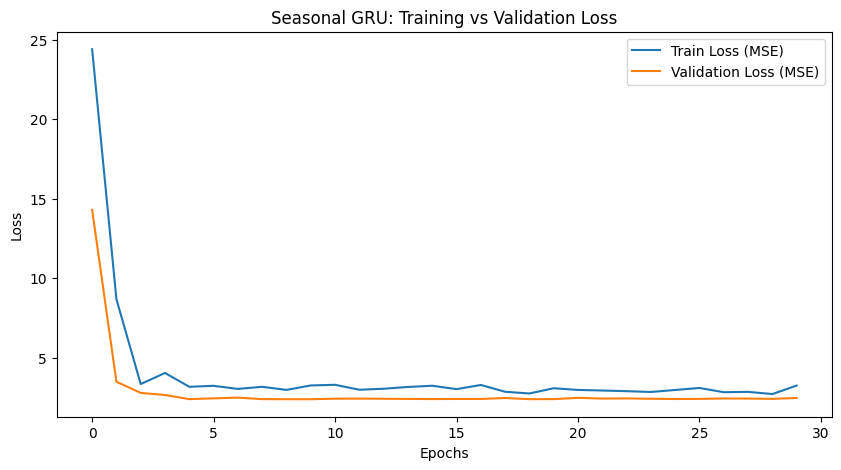

✅ Seasonal Model Test MSE: 2.3961, Test MAE: 1.1850
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001CF76AED240> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 836ms/step


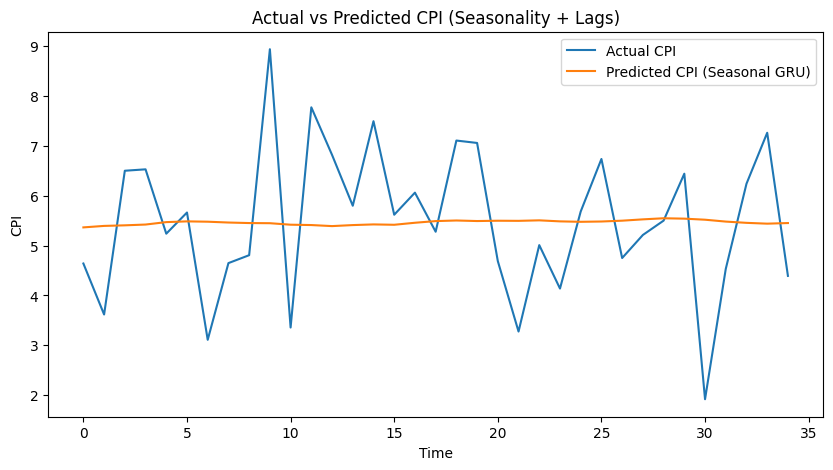

In [10]:
# 8 Retrain with Seasonality + Deeper Lags

features = df_seasonal.drop(columns=["Date"])
target = df_seasonal["CPI"]

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 12
X_seq, y_seq = create_sequences(features_scaled, target, TIME_STEPS)

train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"✅ New sequences ready! Train: {X_train.shape}, Test: {X_test.shape}")

# from tensorflow.keras.regularizers import l2
l2 = tf.keras.regularizers.l2

model = Sequential([
    GRU(128, activation="tanh", return_sequences=True,
        kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    GRU(64, activation="tanh", kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss="mse", metrics=["mae"])

early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history_seasonal = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(10, 5))
plt.plot(history_seasonal.history["loss"], label="Train Loss (MSE)")
plt.plot(history_seasonal.history["val_loss"], label="Validation Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Seasonal GRU: Training vs Validation Loss")
plt.show()

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Seasonal Model Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

y_pred_seasonal = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual CPI")
plt.plot(y_pred_seasonal, label="Predicted CPI (Seasonal GRU)")
plt.xlabel("Time")
plt.ylabel("CPI")
plt.legend()
plt.title("Actual vs Predicted CPI (Seasonality + Lags)")
plt.show()


In [11]:
model.save("Binflation_gru_model.h5")
